In [1]:
import tensorflow as tf

2024-04-07 20:59:37.843370: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-07 20:59:42.026060: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from tensorflow import keras as keras
from keras import layers as layers

In [3]:
import os, timeit
from skimage.filters import threshold_otsu
import numpy as np
from math import inf as inf

In [4]:
import pandas as pd

In [5]:
from spectral.io import envi as envi
from spectral import imshow

In [6]:
from sklearn.decomposition import IncrementalPCA

In [7]:
import sys

In [8]:
import random

tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

In [9]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(physical_devices[1], 'GPU')

Num GPUs Available:  2


In [10]:
from sys import platform
DATA_DIRECTORY = ""
SLASH = ""
if platform == "linux" or platform == "linux2":
    DATA_DIRECTORY = "/home/tyagi/Desktop/wheat/data/BULK/"
    SLASH = "/"
elif platform == "win32":
    DATA_DIRECTORY = "D:\wheat\data\BULK\\"
    SLASH="\\"

In [11]:
#Constants
BAND_NUMBER = 60
FILLED_AREA_RATIO = 0.9
TRAIN_IMAGE_COUNT = 1200
VAL_IMAGE_COUNT = 400
TEST_IMAGE_COUNT = 400
NUM_VARIETIES = 4

IMAGE_WIDTH = 30
IMAGE_HEIGHT = 30

In [12]:
ACTIVATION_TYPE =  "relu"
BATCH_SIZE = 2*NUM_VARIETIES
LEARNING_RATE_BASE = 0.0001

In [13]:
from enum import Enum

class filter_method(Enum):
    none = 0
    snv = 1
    msc = 2
    savgol = 3
    
FILTER = filter_method(0).name

# to be set if filter chosen is savgol
WINDOW = 7
ORDER = 2
DERIVATIVE = "none"

In [14]:
from enum import Enum
 
class feature_extraction_method(Enum):
    none = 0
    pca_loading = 1
    lda = 2
    ipca = 3

FEATURE_EXTRACTION = feature_extraction_method(0).name

NUM_OF_BANDS = 3
if FEATURE_EXTRACTION == "pca_loading" or FEATURE_EXTRACTION == "ipca":
    NUM_OF_BANDS = 8
elif FEATURE_EXTRACTION == "lda":
    NUM_OF_BANDS = 3
    assert NUM_OF_BANDS <= min(NUM_VARIETIES-1,168),"NUM_OF_BANDS is greater."


REMOVE_NOISY_BANDS = False
FIRST_BAND = 15
LAST_BAND = 161

In [15]:
def start_timer():
    print("Testing started")
    return timeit.default_timer()

def end_timer():
    return timeit.default_timer()

def show_time(tic,toc): 
    test_time = toc - tic
    print('Testing time (s) = ' + str(test_time) + '\n')

In [16]:
# List for All varieties
VARIETIES = []
VARIETIES_CODE = {}

for name in os.listdir(DATA_DIRECTORY):
    if (name.endswith(".hdr") or name.endswith(".bil")):
        continue
    VARIETIES_CODE[name] = len(VARIETIES)
    VARIETIES.append(name)
    if len(VARIETIES)==NUM_VARIETIES:
        break

In [17]:
def dataset_file_name(variety):
    name = "./dataset/V"+str(variety).zfill(3)+"_FilledArea_"+str(FILLED_AREA_RATIO)+"_NumOfBands_"+str(NUM_OF_BANDS)+"_FB_"+str(FIRST_BAND)+"_LB_"+str(LAST_BAND)+"_BandNo_"+str(BAND_NUMBER)+"_ImageHeight_"+str(IMAGE_HEIGHT)+"_ImageWidth_"+str(IMAGE_WIDTH)+"_FILTER_"+str(FILTER)+"_FeatureExtraction_"+str(FEATURE_EXTRACTION)
    if REMOVE_NOISY_BANDS:
        name+="_REMOVE_NOISY_BANDS_"+str(REMOVE_NOISY_BANDS)
    if FILTER == "savgol":
        name+="_WINDOW_"+str(WINDOW)+"_ORDER_"+str(ORDER)
    return name

In [18]:
x_train = []
y_train = []
x_val = []
y_val = []
test_dataset=[]
test_dataset_label = []

for idx, v in enumerate(VARIETIES):
    print("idx: ",idx)
    if idx >= NUM_VARIETIES:
        break
    x_train= x_train + np.load(dataset_file_name(v)+"_train_dataset.npy").tolist()
    y_train = y_train + np.load(dataset_file_name(v)+"_train_dataset_label.npy").tolist()
    x_val= x_val + np.load(dataset_file_name(v)+"_val_dataset.npy").tolist()
    y_val = y_val + np.load(dataset_file_name(v)+"_val_dataset_label.npy").tolist()
    test_dataset = test_dataset + np.load(dataset_file_name(v)+"_test_dataset.npy").tolist()
    test_dataset_label = test_dataset_label + np.load(dataset_file_name(v)+"_test_dataset_label.npy").tolist()
    
x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)
test_dataset = np.array(test_dataset)
test_dataset_label = np.array(test_dataset_label)

idx:  0
idx:  1
idx:  2
idx:  3


In [19]:
import matplotlib.pyplot as plt
import numpy as np
import keras
import keras.backend as K
import tensorflow as tf
from keras.layers import Dropout, Input, Conv2D, MaxPooling2D, Activation, BatchNormalization, Add, Conv2DTranspose, Flatten, Dense, Conv1D, AveragePooling2D, LeakyReLU, PReLU, GlobalAveragePooling2D
from keras.layers import concatenate
from keras.models import Model

import os, pdb, timeit
import numpy as np
from keras.callbacks import TensorBoard
from keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.cm as cm

In [20]:
def normalizeDataWholeSeed(data,normalization_type='max'):
    
    if normalization_type == 'max':
        for idx in range(data.shape[0]):
            data[idx,:,:,:] = data[idx,:,:,:]/np.max(abs(data[idx,:,:,:]))
            
    elif normalization_type == 'l2norm':
        from numpy import linalg as LA
        for idx in range(data.shape[0]):
            data[idx,:,:,:] = data[idx,:,:,:]/LA.norm(data[idx,:,:,:]) # L2-norm by default        
        
    return data

In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [22]:
import seaborn as sn
import pandas as pd

In [23]:
def evaluate(model,dataset,dataset_label,normalization_type):
    print("--------------Make Predictions--------------")    
    x = np.array(dataset)
    labels = np.array(dataset_label)
    
    # Normalize the data
    x = normalizeDataWholeSeed(x,normalization_type=normalization_type)
    
    num = x.shape[0]

    print("Testing started")
    tic = timeit.default_timer()
    labels_predicted = model.predict(x)
    toc = timeit.default_timer()
    test_time = toc - tic
    print('Testing time (s) = ' + str(test_time) + '\n')
    
    print("--------")
    # Classification accuracy
    labels_integer_format = labels
    labels_predicted_integer_format = np.argmax(labels_predicted, axis=1)
    
    # Calculate accuracy
    accuracy = accuracy_score(labels_integer_format, labels_predicted_integer_format)
    print("Accuracy:", accuracy)
    
    # Confusion matrices
    confusion_matrix_results = confusion_matrix(labels_integer_format, labels_predicted_integer_format)
    print("Confusion matrix = ")
    print(confusion_matrix_results)
    print("------------------------------------------------")
    
    df_cm = pd.DataFrame(confusion_matrix_results,index =[i for i in VARIETIES],columns=[i for i in VARIETIES])
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='.0f') # font size

    plt.show()

    # Calculate precision, recall, and F1-score for each class
    print("Classification Report:")
    print(classification_report(labels_integer_format, labels_predicted_integer_format))

In [24]:
def predict(model,normalization_type):
    evaluate(model,test_dataset,test_dataset_label,normalization_type)

In [25]:
def plot_graph(df,title,xlabel,ylabel,values=['loss'],legends=[]):
    
    for value in values:
        epoch_count = range(1, len(df.index) + 1)
        plt.plot(epoch_count, df[value].tolist())
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if legends==[]:
        legends = values
    plt.legend(legends, loc='upper left')
    plt.show()

In [26]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, concatenate
import tensorflow.keras.backend as K
# Creating Densenet121
def densenet(input_shape, n_classes, filters = 32):
    
    #batch norm + relu + conv
    def bn_rl_conv(x,filters,kernel=1,strides=1):
        
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(filters, kernel, strides=strides,padding = 'same')(x)
        return x
    
    def dense_block(x, repetition):
        
        for _ in range(repetition):
            y = bn_rl_conv(x, 4*filters)
            y = bn_rl_conv(y, filters, 3)
            x = concatenate([y,x])
        return x
        
    def transition_layer(x):
        
        x = bn_rl_conv(x, K.int_shape(x)[-1] //2 )
        x = AvgPool2D(2, strides = 2, padding = 'same')(x)
        return x
    
    input = Input (input_shape)
    x = Conv2D(64, 7, strides = 2, padding = 'same')(input)
    x = MaxPool2D(3, strides = 2, padding = 'same')(x)
    
    for repetition in [6,12,24,16]:
        
        d = dense_block(x, repetition)
        x = transition_layer(d)
    x = GlobalAveragePooling2D()(d)
    output = Dense(n_classes, activation = 'softmax')(x)
    
    model = Model(input, output)
    return model

In [27]:
x_training = np.array(x_train)
labels_training = np.array(y_train)

# Normalize the data
x_training = normalizeDataWholeSeed(x_training,normalization_type='max')
x_val_norm = normalizeDataWholeSeed(x_val,normalization_type="max")
test_dataset = normalizeDataWholeSeed(test_dataset,normalization_type='max')
    
# Extract some information
num_training = x_training.shape[0]
N_spatial = x_training.shape[1:3]
N_bands = x_training.shape[3]
batch_size = BATCH_SIZE
num_batch_per_epoch = int(num_training/batch_size)

In [28]:
import pandas as pd
import os

def save_to_csv(file_path, data_frame, header=False):
    file_exists = os.path.exists(file_path)

    if not file_exists or not header:
        data_frame.to_csv(file_path, index=False, mode='w')
    else:
        data_frame.to_csv(file_path, index=False, mode='a', header=False)

In [29]:
VARIETIES

['HD 3086', 'PBW 291', 'DBW 187', 'DBW222']

In [30]:
from tensorflow.keras import datasets, layers, models, losses, Model

In [31]:
model = None

In [32]:
start_epoch = 1

In [33]:
model_name = "DN121_"+"_IC_"+str(TRAIN_IMAGE_COUNT).zfill(5)+"_FilledArea_"+str(FILLED_AREA_RATIO)+"_BandNo_"+str(BAND_NUMBER)+"_ImageHeight_"+str(IMAGE_HEIGHT)+"_ImageWidth_"+str(IMAGE_WIDTH)+"_FILTER_"+str(FILTER)+"_FeatureExtraction_"+str(FEATURE_EXTRACTION)
if REMOVE_NOISY_BANDS:
    model_name+="_REMOVE_NOISY_BANDS_"+str(REMOVE_NOISY_BANDS)+"_NumOfBands_"+str(NUM_OF_BANDS)+"_FB_"+str(FIRST_BAND)+"_LB_"+str(LAST_BAND)
if FILTER == "savgol":
    model_name+="_WINDOW_"+str(WINDOW)+"_ORDER_"+str(ORDER)

if start_epoch != 1:
    model = tf.keras.models.load_model('./DN121models/'+str(start_epoch-1)+model_name)
else:
    input_shape = (30, 30, 168)
    num_classes = 4
    model = densenet(input_shape, num_classes)
    adam_opt = Adam(learning_rate=LEARNING_RATE_BASE, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=adam_opt, metrics=['acc'])

2024-04-07 21:05:02.575951: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14539 MB memory:  -> device: 1, name: Quadro P5000, pci bus id: 0000:9b:00.0, compute capability: 6.1


In [34]:
last_epoch = 100

In [35]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30, 30, 168)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 15, 15, 64)           526912    ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 8, 8, 64)             0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 8, 8, 64)             256       ['max_pooling2d[0][0]']   

 )                                                                   'concatenate_2[0][0]']       
                                                                                                  
 batch_normalization_8 (Bat  (None, 8, 8, 192)            768       ['concatenate_3[0][0]']       
 chNormalization)                                                                                 
                                                                                                  
 re_lu_8 (ReLU)              (None, 8, 8, 192)            0         ['batch_normalization_8[0][0]'
                                                                    ]                             
                                                                                                  
 conv2d_9 (Conv2D)           (None, 8, 8, 128)            24704     ['re_lu_8[0][0]']             
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_17 (Conv2D)          (None, 4, 4, 32)             36896     ['re_lu_16[0][0]']            
                                                                                                  
 concatenate_7 (Concatenate  (None, 4, 4, 192)            0         ['conv2d_17[0][0]',           
 )                                                                   'concatenate_6[0][0]']       
                                                                                                  
 batch_normalization_17 (Ba  (None, 4, 4, 192)            768       ['concatenate_7[0][0]']       
 tchNormalization)                                                                                
                                                                                                  
 re_lu_17 (ReLU)             (None, 4, 4, 192)            0         ['batch_normalization_17[0][0]
          

 tchNormalization)                                                                                
                                                                                                  
 re_lu_25 (ReLU)             (None, 4, 4, 320)            0         ['batch_normalization_25[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_26 (Conv2D)          (None, 4, 4, 128)            41088     ['re_lu_25[0][0]']            
                                                                                                  
 batch_normalization_26 (Ba  (None, 4, 4, 128)            512       ['conv2d_26[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_26 

 batch_normalization_34 (Ba  (None, 4, 4, 128)            512       ['conv2d_34[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_34 (ReLU)             (None, 4, 4, 128)            0         ['batch_normalization_34[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_35 (Conv2D)          (None, 4, 4, 32)             36896     ['re_lu_34[0][0]']            
                                                                                                  
 concatenate_16 (Concatenat  (None, 4, 4, 480)            0         ['conv2d_35[0][0]',           
 e)                                                                  'concatenate_15[0][0]']      
          

                                                                    ']                            
                                                                                                  
 conv2d_43 (Conv2D)          (None, 2, 2, 128)            41088     ['re_lu_42[0][0]']            
                                                                                                  
 batch_normalization_43 (Ba  (None, 2, 2, 128)            512       ['conv2d_43[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_43 (ReLU)             (None, 2, 2, 128)            0         ['batch_normalization_43[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_44

 re_lu_51 (ReLU)             (None, 2, 2, 128)            0         ['batch_normalization_51[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_52 (Conv2D)          (None, 2, 2, 32)             36896     ['re_lu_51[0][0]']            
                                                                                                  
 concatenate_24 (Concatenat  (None, 2, 2, 480)            0         ['conv2d_52[0][0]',           
 e)                                                                  'concatenate_23[0][0]']      
                                                                                                  
 batch_normalization_52 (Ba  (None, 2, 2, 480)            1920      ['concatenate_24[0][0]']      
 tchNormalization)                                                                                
          

                                                                                                  
 batch_normalization_60 (Ba  (None, 2, 2, 608)            2432      ['concatenate_28[0][0]']      
 tchNormalization)                                                                                
                                                                                                  
 re_lu_60 (ReLU)             (None, 2, 2, 608)            0         ['batch_normalization_60[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_61 (Conv2D)          (None, 2, 2, 128)            77952     ['re_lu_60[0][0]']            
                                                                                                  
 batch_normalization_61 (Ba  (None, 2, 2, 128)            512       ['conv2d_61[0][0]']           
 tchNormal

 conv2d_69 (Conv2D)          (None, 2, 2, 128)            94336     ['re_lu_68[0][0]']            
                                                                                                  
 batch_normalization_69 (Ba  (None, 2, 2, 128)            512       ['conv2d_69[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_69 (ReLU)             (None, 2, 2, 128)            0         ['batch_normalization_69[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_70 (Conv2D)          (None, 2, 2, 32)             36896     ['re_lu_69[0][0]']            
                                                                                                  
 concatena

                                                                                                  
 conv2d_78 (Conv2D)          (None, 2, 2, 32)             36896     ['re_lu_77[0][0]']            
                                                                                                  
 concatenate_37 (Concatenat  (None, 2, 2, 896)            0         ['conv2d_78[0][0]',           
 e)                                                                  'concatenate_36[0][0]']      
                                                                                                  
 batch_normalization_78 (Ba  (None, 2, 2, 896)            3584      ['concatenate_37[0][0]']      
 tchNormalization)                                                                                
                                                                                                  
 re_lu_78 (ReLU)             (None, 2, 2, 896)            0         ['batch_normalization_78[0][0]
          

 tchNormalization)                                                                                
                                                                                                  
 re_lu_86 (ReLU)             (None, 2, 2, 1024)           0         ['batch_normalization_86[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_87 (Conv2D)          (None, 2, 2, 512)            524800    ['re_lu_86[0][0]']            
                                                                                                  
 average_pooling2d_2 (Avera  (None, 1, 1, 512)            0         ['conv2d_87[0][0]']           
 gePooling2D)                                                                                     
                                                                                                  
 batch_nor

 concatenate_45 (Concatenat  (None, 1, 1, 640)            0         ['conv2d_95[0][0]',           
 e)                                                                  'concatenate_44[0][0]']      
                                                                                                  
 batch_normalization_95 (Ba  (None, 1, 1, 640)            2560      ['concatenate_45[0][0]']      
 tchNormalization)                                                                                
                                                                                                  
 re_lu_95 (ReLU)             (None, 1, 1, 640)            0         ['batch_normalization_95[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_96 (Conv2D)          (None, 1, 1, 128)            82048     ['re_lu_95[0][0]']            
          

                                                                    ]']                           
                                                                                                  
 conv2d_104 (Conv2D)         (None, 1, 1, 128)            98432     ['re_lu_103[0][0]']           
                                                                                                  
 batch_normalization_104 (B  (None, 1, 1, 128)            512       ['conv2d_104[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 re_lu_104 (ReLU)            (None, 1, 1, 128)            0         ['batch_normalization_104[0][0
                                                                    ]']                           
                                                                                                  
 conv2d_10

 re_lu_112 (ReLU)            (None, 1, 1, 128)            0         ['batch_normalization_112[0][0
                                                                    ]']                           
                                                                                                  
 conv2d_113 (Conv2D)         (None, 1, 1, 32)             36896     ['re_lu_112[0][0]']           
                                                                                                  
 concatenate_54 (Concatenat  (None, 1, 1, 928)            0         ['conv2d_113[0][0]',          
 e)                                                                  'concatenate_53[0][0]']      
                                                                                                  
 batch_normalization_113 (B  (None, 1, 1, 928)            3712      ['concatenate_54[0][0]']      
 atchNormalization)                                                                               
          

In [36]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

tic = start_timer()
while start_epoch<=last_epoch:
    print("\nEpoch: ",start_epoch)
    history = model.fit(x_training, labels_training, batch_size=batch_size, epochs = 1, validation_data=(x_val_norm, y_val), verbose=2)
    model.save('./DN121models/'+str(start_epoch)+model_name)
    print("Model saved on epoch: ",start_epoch)
    
    history_dataframe = pd.DataFrame.from_dict(history.history)
    save_to_csv('./csvs/'+model_name+'.csv', history_dataframe, header=True)
    print("added to csv")
    
    y_pred = model.predict(test_dataset)

    y_pred_label = np.argmax(y_pred, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(test_dataset_label, y_pred_label)
    print("Accuracy:", accuracy)

    # Calculate confusion matrix
    cm = confusion_matrix(test_dataset_label, y_pred_label)
    print("Confusion Matrix:")
    print(cm)

    # Calculate precision, recall, and F1-score for each class
    print("Classification Report:")
    print(classification_report(test_dataset_label, y_pred_label))
    start_epoch+=1
    
toc = end_timer()
show_time(tic,toc)


Testing started

Epoch:  1


2024-04-07 21:05:52.551842: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-04-07 21:05:54.068254: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x73a340560030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-07 21:05:54.068311: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro P5000, Compute Capability 6.1
2024-04-07 21:05:54.595597: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-07 21:05:55.982609: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


600/600 - 172s - loss: 1.1372 - acc: 0.4877 - val_loss: 1.3319 - val_acc: 0.4619 - 172s/epoch - 287ms/step
INFO:tensorflow:Assets written to: ./DN121models/1DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/1DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  1
added to csv
50/50 [==============================] - 5s 28ms/step
Accuracy: 0.436875
Confusion Matrix:
[[212   6  82 100]
 [ 82 155 100  63]
 [130  45 145  80]
 [173   0  40 187]]
Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.53      0.43       400
           1       0.75      0.39      0.51       400
           2       0.40      0.36      0.38       400
           3       0.43      0.47      0.45       400

    accuracy                           0.44      1600
   macro avg       0.48      0.44      0.44      1600
weighted avg       0.48      0.44      0.44      1600


Epoch:  2
600/600 - 68s - loss: 0.8420 - acc: 0.6610 - val_loss: 1.3936 - val_acc: 0.4581 - 68s/epoch - 113ms/step
INFO:tensorflow:Assets written to: ./DN121models/2DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/2DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  2
added to csv
50/50 [==============================] - 1s 26ms/step
Accuracy: 0.410625
Confusion Matrix:
[[ 55  13 332   0]
 [  1 220 179   0]
 [  1  49 350   0]
 [ 21  15 332  32]]
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.14      0.23       400
           1       0.74      0.55      0.63       400
           2       0.29      0.88      0.44       400
           3       1.00      0.08      0.15       400

    accuracy                           0.41      1600
   macro avg       0.68      0.41      0.36      1600
weighted avg       0.68      0.41      0.36      1600


Epoch:  3
600/600 - 66s - loss: 0.6620 - acc: 0.7367 - val_loss: 5.7906 - val_acc: 0.2688 - 66s/epoch - 110ms/step
INFO:tensorflow:Assets written to: ./DN121models/3DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/3DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  3
added to csv
50/50 [==============================] - 2s 32ms/step
Accuracy: 0.264375
Confusion Matrix:
[[  0   1   0 399]
 [  1  20   0 379]
 [  0   9   3 388]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       400
           1       0.67      0.05      0.09       400
           2       1.00      0.01      0.01       400
           3       0.26      1.00      0.41       400

    accuracy                           0.26      1600
   macro avg       0.48      0.26      0.13      1600
weighted avg       0.48      0.26      0.13      1600


Epoch:  4
600/600 - 67s - loss: 0.4895 - acc: 0.8156 - val_loss: 3.6476 - val_acc: 0.4306 - 67s/epoch - 112ms/step
INFO:tensorflow:Assets written to: ./DN121models/4DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/4DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  4
added to csv
50/50 [==============================] - 1s 26ms/step
Accuracy: 0.464375
Confusion Matrix:
[[ 48  13   2 337]
 [ 34 151  13 202]
 [ 66  52 145 137]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.12      0.18       400
           1       0.70      0.38      0.49       400
           2       0.90      0.36      0.52       400
           3       0.37      1.00      0.54       400

    accuracy                           0.46      1600
   macro avg       0.57      0.46      0.43      1600
weighted avg       0.57      0.46      0.43      1600


Epoch:  5
600/600 - 66s - loss: 0.3498 - acc: 0.8702 - val_loss: 14.7065 - val_acc: 0.2500 - 66s/epoch - 109ms/step
INFO:tensorflow:Assets written to: ./DN121models/5DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/5DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  5
added to csv
50/50 [==============================] - 2s 31ms/step
Accuracy: 0.25
Confusion Matrix:
[[  0   0   0 400]
 [  0   0   0 400]
 [  0   0   0 400]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       400
           1       0.00      0.00      0.00       400
           2       0.00      0.00      0.00       400
           3       0.25      1.00      0.40       400

    accuracy                           0.25      1600
   macro avg       0.06      0.25      0.10      1600
weighted avg       0.06      0.25      0.10      1600


Epoch:  6


/home/tyagi/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tyagi/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tyagi/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


600/600 - 67s - loss: 0.2314 - acc: 0.9137 - val_loss: 9.5904 - val_acc: 0.2812 - 67s/epoch - 112ms/step
INFO:tensorflow:Assets written to: ./DN121models/6DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/6DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  6
added to csv
50/50 [==============================] - 2s 32ms/step
Accuracy: 0.299375
Confusion Matrix:
[[  0   0   0 400]
 [  0  69   0 331]
 [  0  11  10 379]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       400
           1       0.86      0.17      0.29       400
           2       1.00      0.03      0.05       400
           3       0.26      1.00      0.42       400

    accuracy                           0.30      1600
   macro avg       0.53      0.30      0.19      1600
weighted avg       0.53      0.30      0.19      1600


Epoch:  7


/home/tyagi/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tyagi/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tyagi/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


600/600 - 69s - loss: 0.1530 - acc: 0.9469 - val_loss: 6.4818 - val_acc: 0.3981 - 69s/epoch - 115ms/step
INFO:tensorflow:Assets written to: ./DN121models/7DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/7DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  7
added to csv
50/50 [==============================] - 1s 26ms/step
Accuracy: 0.43625
Confusion Matrix:
[[  0   1  57 342]
 [  1  14 127 258]
 [  0   0 284 116]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       400
           1       0.93      0.04      0.07       400
           2       0.61      0.71      0.65       400
           3       0.36      1.00      0.53       400

    accuracy                           0.44      1600
   macro avg       0.47      0.44      0.31      1600
weighted avg       0.47      0.44      0.31      1600


Epoch:  8
600/600 - 67s - loss: 0.1422 - acc: 0.9465 - val_loss: 3.6289 - val_acc: 0.5475 - 67s/epoch - 112ms/step
INFO:tensorflow:Assets written to: ./DN121models/8DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/8DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  8
added to csv
50/50 [==============================] - 1s 23ms/step
Accuracy: 0.55625
Confusion Matrix:
[[ 74   0 257  69]
 [  9  19 367   5]
 [  0   0 399   1]
 [  0   0   2 398]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.18      0.31       400
           1       1.00      0.05      0.09       400
           2       0.39      1.00      0.56       400
           3       0.84      0.99      0.91       400

    accuracy                           0.56      1600
   macro avg       0.78      0.56      0.47      1600
weighted avg       0.78      0.56      0.47      1600


Epoch:  9
600/600 - 65s - loss: 0.1111 - acc: 0.9592 - val_loss: 4.3717 - val_acc: 0.5131 - 65s/epoch - 109ms/step
INFO:tensorflow:Assets written to: ./DN121models/9DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/9DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  9
added to csv
50/50 [==============================] - 2s 29ms/step
Accuracy: 0.545
Confusion Matrix:
[[ 71   0 259  70]
 [ 29  26 336   9]
 [  0   0 394   6]
 [  0   0  19 381]]
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.18      0.28       400
           1       1.00      0.07      0.12       400
           2       0.39      0.98      0.56       400
           3       0.82      0.95      0.88       400

    accuracy                           0.55      1600
   macro avg       0.73      0.55      0.46      1600
weighted avg       0.73      0.55      0.46      1600


Epoch:  10
600/600 - 76s - loss: 0.0929 - acc: 0.9650 - val_loss: 3.9272 - val_acc: 0.4631 - 76s/epoch - 127ms/step
INFO:tensorflow:Assets written to: ./DN121models/10DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/10DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  10
added to csv
50/50 [==============================] - 2s 32ms/step
Accuracy: 0.4225
Confusion Matrix:
[[199 197   4   0]
 [  8 392   0   0]
 [ 32 312  56   0]
 [ 79 292   0  29]]
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.50      0.55       400
           1       0.33      0.98      0.49       400
           2       0.93      0.14      0.24       400
           3       1.00      0.07      0.14       400

    accuracy                           0.42      1600
   macro avg       0.72      0.42      0.36      1600
weighted avg       0.72      0.42      0.36      1600


Epoch:  11
600/600 - 77s - loss: 0.0959 - acc: 0.9669 - val_loss: 1.0496 - val_acc: 0.7769 - 77s/epoch - 129ms/step
INFO:tensorflow:Assets written to: ./DN121models/11DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/11DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  11
added to csv
50/50 [==============================] - 2s 32ms/step
Accuracy: 0.75625
Confusion Matrix:
[[246  97  18  39]
 [ 37 348   9   6]
 [ 38 125 233   4]
 [ 12   4   1 383]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.61      0.67       400
           1       0.61      0.87      0.71       400
           2       0.89      0.58      0.70       400
           3       0.89      0.96      0.92       400

    accuracy                           0.76      1600
   macro avg       0.78      0.76      0.75      1600
weighted avg       0.78      0.76      0.75      1600


Epoch:  12
600/600 - 77s - loss: 0.0800 - acc: 0.9727 - val_loss: 6.5648 - val_acc: 0.4050 - 77s/epoch - 128ms/step
INFO:tensorflow:Assets written to: ./DN121models/12DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/12DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  12
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.435625
Confusion Matrix:
[[  2   6   4 388]
 [  8 155  37 200]
 [  1   6 140 253]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.18      0.01      0.01       400
           1       0.93      0.39      0.55       400
           2       0.77      0.35      0.48       400
           3       0.32      1.00      0.49       400

    accuracy                           0.44      1600
   macro avg       0.55      0.44      0.38      1600
weighted avg       0.55      0.44      0.38      1600


Epoch:  13
600/600 - 78s - loss: 0.0760 - acc: 0.9748 - val_loss: 5.8368 - val_acc: 0.4712 - 78s/epoch - 129ms/step
INFO:tensorflow:Assets written to: ./DN121models/13DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/13DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  13
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.5325
Confusion Matrix:
[[110   0 102 188]
 [100  11 271  18]
 [  4   0 333  63]
 [  0   0   2 398]]
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.28      0.36       400
           1       1.00      0.03      0.05       400
           2       0.47      0.83      0.60       400
           3       0.60      0.99      0.75       400

    accuracy                           0.53      1600
   macro avg       0.65      0.53      0.44      1600
weighted avg       0.65      0.53      0.44      1600


Epoch:  14
600/600 - 66s - loss: 0.0740 - acc: 0.9748 - val_loss: 10.2213 - val_acc: 0.5269 - 66s/epoch - 109ms/step
INFO:tensorflow:Assets written to: ./DN121models/14DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/14DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  14
added to csv
50/50 [==============================] - 1s 29ms/step
Accuracy: 0.53875
Confusion Matrix:
[[322  38  40   0]
 [ 55 333  12   0]
 [ 37 156 207   0]
 [310  12  78   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.81      0.57       400
           1       0.62      0.83      0.71       400
           2       0.61      0.52      0.56       400
           3       0.00      0.00      0.00       400

    accuracy                           0.54      1600
   macro avg       0.42      0.54      0.46      1600
weighted avg       0.42      0.54      0.46      1600


Epoch:  15


/home/tyagi/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tyagi/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tyagi/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


600/600 - 72s - loss: 0.0352 - acc: 0.9883 - val_loss: 1.2765 - val_acc: 0.7306 - 72s/epoch - 121ms/step
INFO:tensorflow:Assets written to: ./DN121models/15DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/15DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  15
added to csv
50/50 [==============================] - 2s 31ms/step
Accuracy: 0.754375
Confusion Matrix:
[[301  89  10   0]
 [ 28 365   7   0]
 [ 32 124 244   0]
 [ 54  33  16 297]]
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.75      0.74       400
           1       0.60      0.91      0.72       400
           2       0.88      0.61      0.72       400
           3       1.00      0.74      0.85       400

    accuracy                           0.75      1600
   macro avg       0.80      0.75      0.76      1600
weighted avg       0.80      0.75      0.76      1600


Epoch:  16
600/600 - 92s - loss: 0.1258 - acc: 0.9592 - val_loss: 1.1165 - val_acc: 0.7387 - 92s/epoch - 153ms/step
INFO:tensorflow:Assets written to: ./DN121models/16DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/16DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  16
added to csv
50/50 [==============================] - 2s 29ms/step
Accuracy: 0.72375
Confusion Matrix:
[[244  21 135   0]
 [ 45 277  78   0]
 [ 11  33 356   0]
 [ 82  11  26 281]]
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.61      0.62       400
           1       0.81      0.69      0.75       400
           2       0.60      0.89      0.72       400
           3       1.00      0.70      0.83       400

    accuracy                           0.72      1600
   macro avg       0.76      0.72      0.73      1600
weighted avg       0.76      0.72      0.73      1600


Epoch:  17
600/600 - 65s - loss: 0.0528 - acc: 0.9825 - val_loss: 2.1202 - val_acc: 0.6488 - 65s/epoch - 109ms/step
INFO:tensorflow:Assets written to: ./DN121models/17DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/17DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  17
added to csv
50/50 [==============================] - 1s 27ms/step
Accuracy: 0.580625
Confusion Matrix:
[[ 66  36 298   0]
 [  0 305  95   0]
 [  0  26 374   0]
 [  6   6 204 184]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.17      0.28       400
           1       0.82      0.76      0.79       400
           2       0.39      0.94      0.55       400
           3       1.00      0.46      0.63       400

    accuracy                           0.58      1600
   macro avg       0.78      0.58      0.56      1600
weighted avg       0.78      0.58      0.56      1600


Epoch:  18
600/600 - 64s - loss: 0.0280 - acc: 0.9898 - val_loss: 9.0415 - val_acc: 0.4125 - 64s/epoch - 107ms/step
INFO:tensorflow:Assets written to: ./DN121models/18DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/18DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  18
added to csv
50/50 [==============================] - 2s 30ms/step
Accuracy: 0.403125
Confusion Matrix:
[[  7   0 393   0]
 [  1  35 364   0]
 [  0   0 400   0]
 [  0   0 197 203]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.02      0.03       400
           1       1.00      0.09      0.16       400
           2       0.30      1.00      0.46       400
           3       1.00      0.51      0.67       400

    accuracy                           0.40      1600
   macro avg       0.79      0.40      0.33      1600
weighted avg       0.79      0.40      0.33      1600


Epoch:  19
600/600 - 66s - loss: 0.0559 - acc: 0.9798 - val_loss: 1.6126 - val_acc: 0.7569 - 66s/epoch - 110ms/step
INFO:tensorflow:Assets written to: ./DN121models/19DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/19DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  19
added to csv
50/50 [==============================] - 1s 24ms/step
Accuracy: 0.811875
Confusion Matrix:
[[334  23  42   1]
 [ 76 293  29   2]
 [ 45  46 309   0]
 [ 34   1   2 363]]
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.83      0.75       400
           1       0.81      0.73      0.77       400
           2       0.81      0.77      0.79       400
           3       0.99      0.91      0.95       400

    accuracy                           0.81      1600
   macro avg       0.82      0.81      0.81      1600
weighted avg       0.82      0.81      0.81      1600


Epoch:  20
600/600 - 66s - loss: 0.0646 - acc: 0.9792 - val_loss: 3.7703 - val_acc: 0.5719 - 66s/epoch - 110ms/step
INFO:tensorflow:Assets written to: ./DN121models/20DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/20DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  20
added to csv
50/50 [==============================] - 1s 28ms/step
Accuracy: 0.64
Confusion Matrix:
[[ 90   0 262  48]
 [ 10 144 243   3]
 [  0   2 392   6]
 [  0   0   2 398]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.23      0.36       400
           1       0.99      0.36      0.53       400
           2       0.44      0.98      0.60       400
           3       0.87      0.99      0.93       400

    accuracy                           0.64      1600
   macro avg       0.80      0.64      0.61      1600
weighted avg       0.80      0.64      0.61      1600


Epoch:  21
600/600 - 66s - loss: 0.0215 - acc: 0.9935 - val_loss: 1.6031 - val_acc: 0.7569 - 66s/epoch - 110ms/step
INFO:tensorflow:Assets written to: ./DN121models/21DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/21DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  21
added to csv
50/50 [==============================] - 1s 27ms/step
Accuracy: 0.7775
Confusion Matrix:
[[185   8 192  15]
 [ 20 269 111   0]
 [  1   5 392   2]
 [  0   0   2 398]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.46      0.61       400
           1       0.95      0.67      0.79       400
           2       0.56      0.98      0.71       400
           3       0.96      0.99      0.98       400

    accuracy                           0.78      1600
   macro avg       0.84      0.78      0.77      1600
weighted avg       0.84      0.78      0.77      1600


Epoch:  22
600/600 - 65s - loss: 0.0792 - acc: 0.9765 - val_loss: 10.6759 - val_acc: 0.5362 - 65s/epoch - 109ms/step
INFO:tensorflow:Assets written to: ./DN121models/22DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/22DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  22
added to csv
50/50 [==============================] - 1s 26ms/step
Accuracy: 0.590625
Confusion Matrix:
[[  0   6  33 361]
 [  0 235  36 129]
 [  0   9 310  81]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       400
           1       0.94      0.59      0.72       400
           2       0.82      0.78      0.80       400
           3       0.41      1.00      0.58       400

    accuracy                           0.59      1600
   macro avg       0.54      0.59      0.53      1600
weighted avg       0.54      0.59      0.53      1600


Epoch:  23


/home/tyagi/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tyagi/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tyagi/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


600/600 - 65s - loss: 0.0599 - acc: 0.9794 - val_loss: 3.2825 - val_acc: 0.6194 - 65s/epoch - 109ms/step
INFO:tensorflow:Assets written to: ./DN121models/23DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/23DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  23
added to csv
50/50 [==============================] - 1s 28ms/step
Accuracy: 0.684375
Confusion Matrix:
[[152   1 168  79]
 [ 41 170 174  15]
 [  0   2 373  25]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.38      0.51       400
           1       0.98      0.42      0.59       400
           2       0.52      0.93      0.67       400
           3       0.77      1.00      0.87       400

    accuracy                           0.68      1600
   macro avg       0.77      0.68      0.66      1600
weighted avg       0.77      0.68      0.66      1600


Epoch:  24
600/600 - 67s - loss: 0.0356 - acc: 0.9869 - val_loss: 1.5978 - val_acc: 0.7925 - 67s/epoch - 112ms/step
INFO:tensorflow:Assets written to: ./DN121models/24DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/24DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  24
added to csv
50/50 [==============================] - 1s 28ms/step
Accuracy: 0.82125
Confusion Matrix:
[[353   4  43   0]
 [128 234  38   0]
 [ 30  15 355   0]
 [ 20   0   8 372]]
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.88      0.76       400
           1       0.92      0.58      0.72       400
           2       0.80      0.89      0.84       400
           3       1.00      0.93      0.96       400

    accuracy                           0.82      1600
   macro avg       0.85      0.82      0.82      1600
weighted avg       0.85      0.82      0.82      1600


Epoch:  25
600/600 - 67s - loss: 0.0181 - acc: 0.9933 - val_loss: 8.9386 - val_acc: 0.4187 - 67s/epoch - 111ms/step
INFO:tensorflow:Assets written to: ./DN121models/25DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/25DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  25
added to csv
50/50 [==============================] - 1s 27ms/step
Accuracy: 0.37875
Confusion Matrix:
[[174 225   1   0]
 [  1 399   0   0]
 [ 21 356  23   0]
 [ 49 341   0  10]]
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.43      0.54       400
           1       0.30      1.00      0.46       400
           2       0.96      0.06      0.11       400
           3       1.00      0.03      0.05       400

    accuracy                           0.38      1600
   macro avg       0.74      0.38      0.29      1600
weighted avg       0.74      0.38      0.29      1600


Epoch:  26
600/600 - 66s - loss: 0.0757 - acc: 0.9769 - val_loss: 76.1699 - val_acc: 0.2500 - 66s/epoch - 110ms/step
INFO:tensorflow:Assets written to: ./DN121models/26DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/26DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  26
added to csv
50/50 [==============================] - 2s 30ms/step
Accuracy: 0.25
Confusion Matrix:
[[  0   0   0 400]
 [  0   0   0 400]
 [  0   0   0 400]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       400
           1       0.00      0.00      0.00       400
           2       0.00      0.00      0.00       400
           3       0.25      1.00      0.40       400

    accuracy                           0.25      1600
   macro avg       0.06      0.25      0.10      1600
weighted avg       0.06      0.25      0.10      1600


Epoch:  27


/home/tyagi/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tyagi/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tyagi/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


600/600 - 64s - loss: 0.0393 - acc: 0.9871 - val_loss: 2.0214 - val_acc: 0.7694 - 64s/epoch - 107ms/step
INFO:tensorflow:Assets written to: ./DN121models/27DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/27DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  27
added to csv
50/50 [==============================] - 1s 29ms/step
Accuracy: 0.785
Confusion Matrix:
[[307   1  91   1]
 [115 185 100   0]
 [ 14   6 380   0]
 [  7   0   9 384]]
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.77      0.73       400
           1       0.96      0.46      0.62       400
           2       0.66      0.95      0.78       400
           3       1.00      0.96      0.98       400

    accuracy                           0.79      1600
   macro avg       0.83      0.78      0.78      1600
weighted avg       0.83      0.79      0.78      1600


Epoch:  28
600/600 - 66s - loss: 0.0283 - acc: 0.9917 - val_loss: 3.4018 - val_acc: 0.6612 - 66s/epoch - 110ms/step
INFO:tensorflow:Assets written to: ./DN121models/28DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/28DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  28
added to csv
50/50 [==============================] - 1s 29ms/step
Accuracy: 0.6925
Confusion Matrix:
[[343  56   1   0]
 [ 46 354   0   0]
 [104 163 133   0]
 [108   9   5 278]]
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.86      0.69       400
           1       0.61      0.89      0.72       400
           2       0.96      0.33      0.49       400
           3       1.00      0.69      0.82       400

    accuracy                           0.69      1600
   macro avg       0.78      0.69      0.68      1600
weighted avg       0.78      0.69      0.68      1600


Epoch:  29
600/600 - 67s - loss: 0.0172 - acc: 0.9931 - val_loss: 20.0621 - val_acc: 0.4631 - 67s/epoch - 111ms/step
INFO:tensorflow:Assets written to: ./DN121models/29DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/29DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  29
added to csv
50/50 [==============================] - 1s 26ms/step
Accuracy: 0.44
Confusion Matrix:
[[337  63   0   0]
 [ 66 334   0   0]
 [203 164  33   0]
 [330  66   4   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.84      0.50       400
           1       0.53      0.83      0.65       400
           2       0.89      0.08      0.15       400
           3       0.00      0.00      0.00       400

    accuracy                           0.44      1600
   macro avg       0.45      0.44      0.33      1600
weighted avg       0.45      0.44      0.33      1600


Epoch:  30


/home/tyagi/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tyagi/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tyagi/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


600/600 - 65s - loss: 0.0721 - acc: 0.9773 - val_loss: 2.1249 - val_acc: 0.6400 - 65s/epoch - 109ms/step
INFO:tensorflow:Assets written to: ./DN121models/30DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/30DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  30
added to csv
50/50 [==============================] - 2s 30ms/step
Accuracy: 0.675625
Confusion Matrix:
[[251 125  24   0]
 [  4 393   3   0]
 [ 21 130 249   0]
 [145  42  25 188]]
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.63      0.61       400
           1       0.57      0.98      0.72       400
           2       0.83      0.62      0.71       400
           3       1.00      0.47      0.64       400

    accuracy                           0.68      1600
   macro avg       0.75      0.68      0.67      1600
weighted avg       0.75      0.68      0.67      1600


Epoch:  31
600/600 - 65s - loss: 0.0303 - acc: 0.9898 - val_loss: 0.9513 - val_acc: 0.8331 - 65s/epoch - 108ms/step
INFO:tensorflow:Assets written to: ./DN121models/31DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/31DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  31
added to csv
50/50 [==============================] - 1s 26ms/step
Accuracy: 0.8025
Confusion Matrix:
[[227   7 166   0]
 [ 26 300  74   0]
 [  1   7 392   0]
 [  9   0  26 365]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.57      0.68       400
           1       0.96      0.75      0.84       400
           2       0.60      0.98      0.74       400
           3       1.00      0.91      0.95       400

    accuracy                           0.80      1600
   macro avg       0.85      0.80      0.81      1600
weighted avg       0.85      0.80      0.81      1600


Epoch:  32
600/600 - 67s - loss: 0.0062 - acc: 0.9977 - val_loss: 0.6929 - val_acc: 0.8737 - 67s/epoch - 111ms/step
INFO:tensorflow:Assets written to: ./DN121models/32DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/32DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  32
added to csv
50/50 [==============================] - 1s 28ms/step
Accuracy: 0.82625
Confusion Matrix:
[[181 105  98  16]
 [  3 394   3   0]
 [  2  45 347   6]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.45      0.62       400
           1       0.72      0.98      0.83       400
           2       0.77      0.87      0.82       400
           3       0.95      1.00      0.97       400

    accuracy                           0.83      1600
   macro avg       0.85      0.83      0.81      1600
weighted avg       0.85      0.83      0.81      1600


Epoch:  33
600/600 - 74s - loss: 0.0013 - acc: 0.9996 - val_loss: 0.5677 - val_acc: 0.9069 - 74s/epoch - 124ms/step
INFO:tensorflow:Assets written to: ./DN121models/33DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/33DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  33
added to csv
50/50 [==============================] - 1s 27ms/step
Accuracy: 0.860625
Confusion Matrix:
[[236  60 104   0]
 [  7 383  10   0]
 [  4  37 359   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.59      0.73       400
           1       0.80      0.96      0.87       400
           2       0.76      0.90      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  34
600/600 - 72s - loss: 1.5745e-04 - acc: 1.0000 - val_loss: 0.5731 - val_acc: 0.9081 - 72s/epoch - 121ms/step
INFO:tensorflow:Assets written to: ./DN121models/34DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/34DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  34
added to csv
50/50 [==============================] - 2s 32ms/step
Accuracy: 0.865
Confusion Matrix:
[[246  48 106   0]
 [  9 374  17   0]
 [  4  31 365   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.61      0.75       400
           1       0.83      0.94      0.88       400
           2       0.75      0.91      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  35
600/600 - 76s - loss: 7.5004e-05 - acc: 1.0000 - val_loss: 0.5834 - val_acc: 0.9062 - 76s/epoch - 127ms/step
INFO:tensorflow:Assets written to: ./DN121models/35DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/35DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  35
added to csv
50/50 [==============================] - 1s 28ms/step
Accuracy: 0.865625
Confusion Matrix:
[[248  46 106   0]
 [  9 372  19   0]
 [  4  30 366   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.62      0.75       400
           1       0.83      0.93      0.88       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.87      1600
   macro avg       0.88      0.87      0.86      1600
weighted avg       0.88      0.87      0.86      1600


Epoch:  36
600/600 - 74s - loss: 5.1742e-05 - acc: 1.0000 - val_loss: 0.5918 - val_acc: 0.9056 - 74s/epoch - 123ms/step
INFO:tensorflow:Assets written to: ./DN121models/36DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/36DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  36
added to csv
50/50 [==============================] - 1s 25ms/step
Accuracy: 0.865
Confusion Matrix:
[[248  45 107   0]
 [  9 371  20   0]
 [  4  30 366   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.62      0.75       400
           1       0.83      0.93      0.88       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  37
600/600 - 75s - loss: 3.8502e-05 - acc: 1.0000 - val_loss: 0.5989 - val_acc: 0.9062 - 75s/epoch - 126ms/step
INFO:tensorflow:Assets written to: ./DN121models/37DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/37DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  37
added to csv
50/50 [==============================] - 1s 26ms/step
Accuracy: 0.863125
Confusion Matrix:
[[245  45 110   0]
 [  9 371  20   0]
 [  4  30 366   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.61      0.74       400
           1       0.83      0.93      0.88       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  38
600/600 - 73s - loss: 2.9165e-05 - acc: 1.0000 - val_loss: 0.6055 - val_acc: 0.9062 - 73s/epoch - 122ms/step
INFO:tensorflow:Assets written to: ./DN121models/38DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/38DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  38
added to csv
50/50 [==============================] - 2s 30ms/step
Accuracy: 0.86375
Confusion Matrix:
[[245  45 110   0]
 [  9 371  20   0]
 [  4  29 367   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.61      0.74       400
           1       0.83      0.93      0.88       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  39
600/600 - 74s - loss: 2.2237e-05 - acc: 1.0000 - val_loss: 0.6126 - val_acc: 0.9056 - 74s/epoch - 124ms/step
INFO:tensorflow:Assets written to: ./DN121models/39DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/39DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  39
added to csv
50/50 [==============================] - 1s 29ms/step
Accuracy: 0.86375
Confusion Matrix:
[[245  45 110   0]
 [  9 371  20   0]
 [  4  29 367   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.61      0.74       400
           1       0.83      0.93      0.88       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  40
600/600 - 73s - loss: 1.6970e-05 - acc: 1.0000 - val_loss: 0.6198 - val_acc: 0.9056 - 73s/epoch - 122ms/step
INFO:tensorflow:Assets written to: ./DN121models/40DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/40DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  40
added to csv
50/50 [==============================] - 2s 30ms/step
Accuracy: 0.864375
Confusion Matrix:
[[245  45 110   0]
 [  9 372  19   0]
 [  4  29 367   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.61      0.74       400
           1       0.83      0.93      0.88       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  41
600/600 - 76s - loss: 1.2914e-05 - acc: 1.0000 - val_loss: 0.6271 - val_acc: 0.9069 - 76s/epoch - 126ms/step
INFO:tensorflow:Assets written to: ./DN121models/41DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/41DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  41
added to csv
50/50 [==============================] - 2s 29ms/step
Accuracy: 0.86375
Confusion Matrix:
[[244  45 111   0]
 [  9 372  19   0]
 [  4  29 367   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.61      0.74       400
           1       0.83      0.93      0.88       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  42
600/600 - 73s - loss: 9.7931e-06 - acc: 1.0000 - val_loss: 0.6349 - val_acc: 0.9075 - 73s/epoch - 121ms/step
INFO:tensorflow:Assets written to: ./DN121models/42DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/42DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  42
added to csv
50/50 [==============================] - 2s 29ms/step
Accuracy: 0.86375
Confusion Matrix:
[[244  45 111   0]
 [  9 372  19   0]
 [  4  29 367   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.61      0.74       400
           1       0.83      0.93      0.88       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  43
600/600 - 75s - loss: 7.4021e-06 - acc: 1.0000 - val_loss: 0.6426 - val_acc: 0.9087 - 75s/epoch - 125ms/step
INFO:tensorflow:Assets written to: ./DN121models/43DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/43DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  43
added to csv
50/50 [==============================] - 1s 25ms/step
Accuracy: 0.864375
Confusion Matrix:
[[244  45 111   0]
 [  8 373  19   0]
 [  4  29 367   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.61      0.74       400
           1       0.83      0.93      0.88       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  44
600/600 - 74s - loss: 5.5698e-06 - acc: 1.0000 - val_loss: 0.6511 - val_acc: 0.9081 - 74s/epoch - 123ms/step
INFO:tensorflow:Assets written to: ./DN121models/44DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/44DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  44
added to csv
50/50 [==============================] - 2s 30ms/step
Accuracy: 0.86375
Confusion Matrix:
[[243  45 112   0]
 [  8 373  19   0]
 [  4  29 367   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.61      0.74       400
           1       0.83      0.93      0.88       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  45
600/600 - 75s - loss: 4.1757e-06 - acc: 1.0000 - val_loss: 0.6600 - val_acc: 0.9081 - 75s/epoch - 126ms/step
INFO:tensorflow:Assets written to: ./DN121models/45DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/45DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  45
added to csv
50/50 [==============================] - 2s 32ms/step
Accuracy: 0.86375
Confusion Matrix:
[[243  45 112   0]
 [  8 373  19   0]
 [  4  29 367   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.61      0.74       400
           1       0.83      0.93      0.88       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  46
600/600 - 92s - loss: 3.1196e-06 - acc: 1.0000 - val_loss: 0.6698 - val_acc: 0.9081 - 92s/epoch - 154ms/step
INFO:tensorflow:Assets written to: ./DN121models/46DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/46DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  46
added to csv
50/50 [==============================] - 2s 32ms/step
Accuracy: 0.864375
Confusion Matrix:
[[243  44 113   0]
 [  8 373  19   0]
 [  4  28 368   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.61      0.74       400
           1       0.84      0.93      0.88       400
           2       0.73      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  47
600/600 - 89s - loss: 2.3212e-06 - acc: 1.0000 - val_loss: 0.6790 - val_acc: 0.9081 - 89s/epoch - 149ms/step
INFO:tensorflow:Assets written to: ./DN121models/47DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/47DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  47
added to csv
50/50 [==============================] - 1s 28ms/step
Accuracy: 0.863125
Confusion Matrix:
[[241  45 114   0]
 [  8 373  19   0]
 [  4  28 368   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.60      0.74       400
           1       0.84      0.93      0.88       400
           2       0.73      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  48
600/600 - 93s - loss: 1.7219e-06 - acc: 1.0000 - val_loss: 0.6886 - val_acc: 0.9075 - 93s/epoch - 155ms/step
INFO:tensorflow:Assets written to: ./DN121models/48DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/48DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  48
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.863125
Confusion Matrix:
[[241  45 114   0]
 [  8 373  19   0]
 [  4  28 368   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.60      0.74       400
           1       0.84      0.93      0.88       400
           2       0.73      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  49
600/600 - 91s - loss: 1.2736e-06 - acc: 1.0000 - val_loss: 0.6988 - val_acc: 0.9062 - 91s/epoch - 152ms/step
INFO:tensorflow:Assets written to: ./DN121models/49DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/49DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  49
added to csv
50/50 [==============================] - 1s 27ms/step
Accuracy: 0.863125
Confusion Matrix:
[[241  45 114   0]
 [  8 373  19   0]
 [  4  28 368   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.60      0.74       400
           1       0.84      0.93      0.88       400
           2       0.73      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  50
600/600 - 79s - loss: 9.4116e-07 - acc: 1.0000 - val_loss: 0.7088 - val_acc: 0.9069 - 79s/epoch - 131ms/step
INFO:tensorflow:Assets written to: ./DN121models/50DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/50DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  50
added to csv
50/50 [==============================] - 2s 30ms/step
Accuracy: 0.8625
Confusion Matrix:
[[240  45 115   0]
 [  8 373  19   0]
 [  4  28 368   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.60      0.74       400
           1       0.84      0.93      0.88       400
           2       0.73      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  51
600/600 - 76s - loss: 6.9407e-07 - acc: 1.0000 - val_loss: 0.7192 - val_acc: 0.9069 - 76s/epoch - 126ms/step
INFO:tensorflow:Assets written to: ./DN121models/51DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/51DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  51
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.86375
Confusion Matrix:
[[240  45 115   0]
 [  8 374  18   0]
 [  4  27 369   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.60      0.74       400
           1       0.84      0.94      0.88       400
           2       0.73      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  52
600/600 - 84s - loss: 5.1064e-07 - acc: 1.0000 - val_loss: 0.7297 - val_acc: 0.9062 - 84s/epoch - 140ms/step
INFO:tensorflow:Assets written to: ./DN121models/52DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/52DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  52
added to csv
50/50 [==============================] - 2s 30ms/step
Accuracy: 0.861875
Confusion Matrix:
[[238  47 115   0]
 [  8 374  18   0]
 [  4  28 368   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.59      0.73       400
           1       0.83      0.94      0.88       400
           2       0.73      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  53
600/600 - 77s - loss: 3.7573e-07 - acc: 1.0000 - val_loss: 0.7401 - val_acc: 0.9062 - 77s/epoch - 128ms/step
INFO:tensorflow:Assets written to: ./DN121models/53DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/53DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  53
added to csv
50/50 [==============================] - 2s 47ms/step
Accuracy: 0.8625
Confusion Matrix:
[[238  47 115   0]
 [  8 374  18   0]
 [  4  27 369   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.59      0.73       400
           1       0.83      0.94      0.88       400
           2       0.73      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  54
600/600 - 71s - loss: 2.7614e-07 - acc: 1.0000 - val_loss: 0.7507 - val_acc: 0.9050 - 71s/epoch - 119ms/step
INFO:tensorflow:Assets written to: ./DN121models/54DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/54DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  54
added to csv
50/50 [==============================] - 2s 30ms/step
Accuracy: 0.8625
Confusion Matrix:
[[239  47 114   0]
 [  8 373  19   0]
 [  4  27 369   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.60      0.73       400
           1       0.83      0.93      0.88       400
           2       0.73      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  55
600/600 - 74s - loss: 2.0236e-07 - acc: 1.0000 - val_loss: 0.7613 - val_acc: 0.9044 - 74s/epoch - 123ms/step
INFO:tensorflow:Assets written to: ./DN121models/55DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/55DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  55
added to csv
50/50 [==============================] - 1s 26ms/step
Accuracy: 0.8625
Confusion Matrix:
[[238  48 114   0]
 [  8 374  18   0]
 [  4  27 369   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.59      0.73       400
           1       0.83      0.94      0.88       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  56
600/600 - 79s - loss: 1.4834e-07 - acc: 1.0000 - val_loss: 0.7724 - val_acc: 0.9044 - 79s/epoch - 132ms/step
INFO:tensorflow:Assets written to: ./DN121models/56DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/56DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  56
added to csv
50/50 [==============================] - 1s 29ms/step
Accuracy: 0.8625
Confusion Matrix:
[[238  48 114   0]
 [  8 374  18   0]
 [  4  27 369   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.59      0.73       400
           1       0.83      0.94      0.88       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  57
600/600 - 91s - loss: 1.0783e-07 - acc: 1.0000 - val_loss: 0.7828 - val_acc: 0.9044 - 91s/epoch - 152ms/step
INFO:tensorflow:Assets written to: ./DN121models/57DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/57DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  57
added to csv
50/50 [==============================] - 2s 32ms/step
Accuracy: 0.861875
Confusion Matrix:
[[237  48 115   0]
 [  8 374  18   0]
 [  4  27 369   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.59      0.73       400
           1       0.83      0.94      0.88       400
           2       0.73      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  58
600/600 - 92s - loss: 7.8902e-08 - acc: 1.0000 - val_loss: 0.7944 - val_acc: 0.9050 - 92s/epoch - 153ms/step
INFO:tensorflow:Assets written to: ./DN121models/58DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/58DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  58
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.860625
Confusion Matrix:
[[235  47 118   0]
 [  8 374  18   0]
 [  4  27 369   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.59      0.73       400
           1       0.83      0.94      0.88       400
           2       0.73      0.92      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  59
600/600 - 93s - loss: 5.8338e-08 - acc: 1.0000 - val_loss: 0.8058 - val_acc: 0.9050 - 93s/epoch - 154ms/step
INFO:tensorflow:Assets written to: ./DN121models/59DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/59DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  59
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.86
Confusion Matrix:
[[236  47 117   0]
 [  8 372  20   0]
 [  4  27 369   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.59      0.73       400
           1       0.83      0.93      0.88       400
           2       0.73      0.92      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  60
600/600 - 93s - loss: 4.1723e-08 - acc: 1.0000 - val_loss: 0.8138 - val_acc: 0.9062 - 93s/epoch - 155ms/step
INFO:tensorflow:Assets written to: ./DN121models/60DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/60DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  60
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.861875
Confusion Matrix:
[[237  47 116   0]
 [  8 374  18   0]
 [  4  27 369   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.59      0.73       400
           1       0.83      0.94      0.88       400
           2       0.73      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  61
600/600 - 92s - loss: 3.0274e-08 - acc: 1.0000 - val_loss: 0.8270 - val_acc: 0.9056 - 92s/epoch - 153ms/step
INFO:tensorflow:Assets written to: ./DN121models/61DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/61DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  61
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.8625
Confusion Matrix:
[[237  47 116   0]
 [  8 373  19   0]
 [  3  27 370   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.59      0.73       400
           1       0.83      0.93      0.88       400
           2       0.73      0.93      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  62
600/600 - 92s - loss: 2.1781e-08 - acc: 1.0000 - val_loss: 0.8326 - val_acc: 0.9062 - 92s/epoch - 153ms/step
INFO:tensorflow:Assets written to: ./DN121models/62DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/62DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  62
added to csv
50/50 [==============================] - 2s 31ms/step
Accuracy: 0.8625
Confusion Matrix:
[[237  47 116   0]
 [  8 374  18   0]
 [  3  28 369   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.59      0.73       400
           1       0.83      0.94      0.88       400
           2       0.73      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  63
600/600 - 93s - loss: 1.5572e-08 - acc: 1.0000 - val_loss: 0.8403 - val_acc: 0.9056 - 93s/epoch - 155ms/step
INFO:tensorflow:Assets written to: ./DN121models/63DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/63DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  63
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.8625
Confusion Matrix:
[[236  49 115   0]
 [  7 375  18   0]
 [  3  28 369   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.59      0.73       400
           1       0.83      0.94      0.88       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  64
600/600 - 92s - loss: 9.6361e-09 - acc: 1.0000 - val_loss: 0.8485 - val_acc: 0.9062 - 92s/epoch - 154ms/step
INFO:tensorflow:Assets written to: ./DN121models/64DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/64DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  64
added to csv
50/50 [==============================] - 2s 30ms/step
Accuracy: 0.861875
Confusion Matrix:
[[235  49 116   0]
 [  7 375  18   0]
 [  3  28 369   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.59      0.73       400
           1       0.83      0.94      0.88       400
           2       0.73      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  65
600/600 - 93s - loss: 6.4323e-09 - acc: 1.0000 - val_loss: 0.8546 - val_acc: 0.9056 - 93s/epoch - 154ms/step
INFO:tensorflow:Assets written to: ./DN121models/65DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/65DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  65
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.861875
Confusion Matrix:
[[235  48 117   0]
 [  7 375  18   0]
 [  3  28 369   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.59      0.73       400
           1       0.83      0.94      0.88       400
           2       0.73      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  66
600/600 - 93s - loss: 3.7998e-09 - acc: 1.0000 - val_loss: 0.8600 - val_acc: 0.9050 - 93s/epoch - 155ms/step
INFO:tensorflow:Assets written to: ./DN121models/66DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/66DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  66
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.860625
Confusion Matrix:
[[233  48 119   0]
 [  8 374  18   0]
 [  3  27 370   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.58      0.72       400
           1       0.83      0.94      0.88       400
           2       0.73      0.93      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  67
600/600 - 93s - loss: 2.1855e-09 - acc: 1.0000 - val_loss: 0.8587 - val_acc: 0.9050 - 93s/epoch - 156ms/step
INFO:tensorflow:Assets written to: ./DN121models/67DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/67DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  67
added to csv
50/50 [==============================] - 2s 32ms/step
Accuracy: 0.86
Confusion Matrix:
[[233  51 116   0]
 [  7 375  18   0]
 [  3  29 368   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.58      0.72       400
           1       0.82      0.94      0.88       400
           2       0.73      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.85      1600
weighted avg       0.88      0.86      0.85      1600


Epoch:  68
600/600 - 93s - loss: 1.0431e-09 - acc: 1.0000 - val_loss: 0.8620 - val_acc: 0.9050 - 93s/epoch - 156ms/step
INFO:tensorflow:Assets written to: ./DN121models/68DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/68DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  68
added to csv
50/50 [==============================] - 2s 32ms/step
Accuracy: 0.860625
Confusion Matrix:
[[233  50 117   0]
 [  7 375  18   0]
 [  3  28 369   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.58      0.72       400
           1       0.83      0.94      0.88       400
           2       0.73      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  69
600/600 - 93s - loss: 5.9605e-10 - acc: 1.0000 - val_loss: 0.8576 - val_acc: 0.9062 - 93s/epoch - 155ms/step
INFO:tensorflow:Assets written to: ./DN121models/69DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/69DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  69
added to csv
50/50 [==============================] - 2s 32ms/step
Accuracy: 0.860625
Confusion Matrix:
[[234  51 115   0]
 [  7 375  18   0]
 [  3  29 368   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.58      0.73       400
           1       0.82      0.94      0.88       400
           2       0.73      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  70
600/600 - 92s - loss: 3.9736e-10 - acc: 1.0000 - val_loss: 0.8625 - val_acc: 0.9044 - 92s/epoch - 154ms/step
INFO:tensorflow:Assets written to: ./DN121models/70DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/70DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  70
added to csv
50/50 [==============================] - 2s 31ms/step
Accuracy: 0.85875
Confusion Matrix:
[[232  52 116   0]
 [  7 375  18   0]
 [  3  30 367   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.58      0.72       400
           1       0.82      0.94      0.88       400
           2       0.73      0.92      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.85      1600
weighted avg       0.88      0.86      0.85      1600


Epoch:  71
600/600 - 93s - loss: 9.9341e-11 - acc: 1.0000 - val_loss: 0.8571 - val_acc: 0.9075 - 93s/epoch - 154ms/step
INFO:tensorflow:Assets written to: ./DN121models/71DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/71DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  71
added to csv
50/50 [==============================] - 2s 30ms/step
Accuracy: 0.86
Confusion Matrix:
[[232  54 114   0]
 [  7 377  16   0]
 [  3  30 367   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.58      0.72       400
           1       0.82      0.94      0.88       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.85      1600
weighted avg       0.88      0.86      0.85      1600


Epoch:  72
600/600 - 96s - loss: 7.4506e-11 - acc: 1.0000 - val_loss: 0.8560 - val_acc: 0.9075 - 96s/epoch - 160ms/step
INFO:tensorflow:Assets written to: ./DN121models/72DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/72DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  72
added to csv
50/50 [==============================] - 2s 29ms/step
Accuracy: 0.86
Confusion Matrix:
[[233  55 112   0]
 [  7 377  16   0]
 [  3  31 366   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.58      0.72       400
           1       0.81      0.94      0.87       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.85      1600
weighted avg       0.88      0.86      0.85      1600


Epoch:  73
600/600 - 85s - loss: 7.4506e-11 - acc: 1.0000 - val_loss: 0.8542 - val_acc: 0.9075 - 85s/epoch - 141ms/step
INFO:tensorflow:Assets written to: ./DN121models/73DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/73DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  73
added to csv
50/50 [==============================] - 1s 27ms/step
Accuracy: 0.861875
Confusion Matrix:
[[236  56 108   0]
 [  6 378  16   0]
 [  3  32 365   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.59      0.73       400
           1       0.81      0.94      0.87       400
           2       0.75      0.91      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  74
600/600 - 74s - loss: 7.4506e-11 - acc: 1.0000 - val_loss: 0.8536 - val_acc: 0.9075 - 74s/epoch - 123ms/step
INFO:tensorflow:Assets written to: ./DN121models/74DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/74DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  74
added to csv
50/50 [==============================] - 1s 29ms/step
Accuracy: 0.861875
Confusion Matrix:
[[237  60 103   0]
 [  6 379  15   0]
 [  3  34 363   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.59      0.73       400
           1       0.80      0.95      0.87       400
           2       0.75      0.91      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  75
600/600 - 83s - loss: 2.4835e-11 - acc: 1.0000 - val_loss: 0.8529 - val_acc: 0.9050 - 83s/epoch - 138ms/step
INFO:tensorflow:Assets written to: ./DN121models/75DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/75DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  75
added to csv
50/50 [==============================] - 2s 32ms/step
Accuracy: 0.864375
Confusion Matrix:
[[240  64  96   0]
 [  6 381  13   0]
 [  4  34 362   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.60      0.74       400
           1       0.80      0.95      0.87       400
           2       0.77      0.91      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  76
600/600 - 93s - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.8552 - val_acc: 0.9056 - 93s/epoch - 155ms/step
INFO:tensorflow:Assets written to: ./DN121models/76DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/76DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  76
added to csv
50/50 [==============================] - 2s 32ms/step
Accuracy: 0.864375
Confusion Matrix:
[[240  64  96   0]
 [  6 380  14   0]
 [  3  34 363   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.60      0.74       400
           1       0.79      0.95      0.87       400
           2       0.77      0.91      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  77
600/600 - 91s - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.8584 - val_acc: 0.9050 - 91s/epoch - 152ms/step
INFO:tensorflow:Assets written to: ./DN121models/77DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/77DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  77
added to csv
50/50 [==============================] - 2s 33ms/step
Accuracy: 0.86375
Confusion Matrix:
[[239  66  95   0]
 [  6 380  14   0]
 [  3  34 363   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.60      0.74       400
           1       0.79      0.95      0.86       400
           2       0.77      0.91      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  78
600/600 - 92s - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.8618 - val_acc: 0.9025 - 92s/epoch - 154ms/step
INFO:tensorflow:Assets written to: ./DN121models/78DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/78DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  78
added to csv
50/50 [==============================] - 1s 29ms/step
Accuracy: 0.86375
Confusion Matrix:
[[242  68  90   0]
 [  6 380  14   0]
 [  4  36 360   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.60      0.74       400
           1       0.79      0.95      0.86       400
           2       0.78      0.90      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  79
600/600 - 88s - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.8655 - val_acc: 0.9025 - 88s/epoch - 147ms/step
INFO:tensorflow:Assets written to: ./DN121models/79DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/79DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  79
added to csv
50/50 [==============================] - 2s 32ms/step
Accuracy: 0.863125
Confusion Matrix:
[[240  70  90   0]
 [  6 381  13   0]
 [  4  36 360   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.60      0.74       400
           1       0.78      0.95      0.86       400
           2       0.78      0.90      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  80
600/600 - 92s - loss: 2.4835e-11 - acc: 1.0000 - val_loss: 0.8690 - val_acc: 0.8994 - 92s/epoch - 154ms/step
INFO:tensorflow:Assets written to: ./DN121models/80DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/80DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  80
added to csv
50/50 [==============================] - 1s 27ms/step
Accuracy: 0.863125
Confusion Matrix:
[[241  69  90   0]
 [  6 380  14   0]
 [  4  36 360   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.60      0.74       400
           1       0.78      0.95      0.86       400
           2       0.78      0.90      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  81
600/600 - 93s - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.8718 - val_acc: 0.9013 - 93s/epoch - 154ms/step
INFO:tensorflow:Assets written to: ./DN121models/81DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/81DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  81
added to csv
50/50 [==============================] - 2s 32ms/step
Accuracy: 0.86375
Confusion Matrix:
[[240  68  92   0]
 [  6 381  13   0]
 [  4  35 361   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.60      0.74       400
           1       0.79      0.95      0.86       400
           2       0.77      0.90      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  82
600/600 - 91s - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.8762 - val_acc: 0.8994 - 91s/epoch - 151ms/step
INFO:tensorflow:Assets written to: ./DN121models/82DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/82DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  82
added to csv
50/50 [==============================] - 1s 26ms/step
Accuracy: 0.86375
Confusion Matrix:
[[241  67  92   0]
 [  6 380  14   0]
 [  4  35 361   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.60      0.74       400
           1       0.79      0.95      0.86       400
           2       0.77      0.90      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  83
600/600 - 93s - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.8795 - val_acc: 0.8994 - 93s/epoch - 155ms/step
INFO:tensorflow:Assets written to: ./DN121models/83DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/83DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  83
added to csv
50/50 [==============================] - 2s 32ms/step
Accuracy: 0.86375
Confusion Matrix:
[[241  64  95   0]
 [  6 380  14   0]
 [  4  35 361   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.60      0.74       400
           1       0.79      0.95      0.86       400
           2       0.77      0.90      0.83       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  84
600/600 - 91s - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.8849 - val_acc: 0.8963 - 91s/epoch - 151ms/step
INFO:tensorflow:Assets written to: ./DN121models/84DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/84DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  84
added to csv
50/50 [==============================] - 2s 32ms/step
Accuracy: 0.86125
Confusion Matrix:
[[240  61  99   0]
 [  6 377  17   0]
 [  4  35 361   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.60      0.74       400
           1       0.80      0.94      0.86       400
           2       0.76      0.90      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.86      1600
weighted avg       0.88      0.86      0.86      1600


Epoch:  85
600/600 - 86s - loss: 2.4835e-11 - acc: 1.0000 - val_loss: 0.8825 - val_acc: 0.8969 - 86s/epoch - 143ms/step
INFO:tensorflow:Assets written to: ./DN121models/85DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/85DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  85
added to csv
50/50 [==============================] - 1s 25ms/step
Accuracy: 0.86
Confusion Matrix:
[[239  60 101   0]
 [  8 376  16   0]
 [  5  34 361   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.60      0.73       400
           1       0.80      0.94      0.86       400
           2       0.76      0.90      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.88      0.86      0.85      1600
weighted avg       0.88      0.86      0.85      1600


Epoch:  86
600/600 - 73s - loss: 0.2572 - acc: 0.9419 - val_loss: 11.1476 - val_acc: 0.4181 - 73s/epoch - 121ms/step
INFO:tensorflow:Assets written to: ./DN121models/86DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/86DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  86
added to csv
50/50 [==============================] - 2s 32ms/step
Accuracy: 0.3575
Confusion Matrix:
[[ 89 304   7   0]
 [  0 397   3   0]
 [  2 313  85   0]
 [222 103  74   1]]
Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.22      0.25       400
           1       0.36      0.99      0.52       400
           2       0.50      0.21      0.30       400
           3       1.00      0.00      0.00       400

    accuracy                           0.36      1600
   macro avg       0.54      0.36      0.27      1600
weighted avg       0.54      0.36      0.27      1600


Epoch:  87
600/600 - 72s - loss: 0.1002 - acc: 0.9656 - val_loss: 0.5490 - val_acc: 0.8756 - 72s/epoch - 120ms/step
INFO:tensorflow:Assets written to: ./DN121models/87DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/87DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  87
added to csv
50/50 [==============================] - 1s 28ms/step
Accuracy: 0.820625
Confusion Matrix:
[[188  40 172   0]
 [ 16 344  40   0]
 [  1  18 381   0]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.47      0.62       400
           1       0.86      0.86      0.86       400
           2       0.64      0.95      0.77       400
           3       1.00      1.00      1.00       400

    accuracy                           0.82      1600
   macro avg       0.85      0.82      0.81      1600
weighted avg       0.85      0.82      0.81      1600


Epoch:  88
600/600 - 74s - loss: 0.0076 - acc: 0.9981 - val_loss: 0.4407 - val_acc: 0.9081 - 74s/epoch - 124ms/step
INFO:tensorflow:Assets written to: ./DN121models/88DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/88DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  88
added to csv
50/50 [==============================] - 2s 29ms/step
Accuracy: 0.86625
Confusion Matrix:
[[262  62  76   0]
 [ 13 373  14   0]
 [ 13  34 353   0]
 [  0   0   2 398]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.66      0.76       400
           1       0.80      0.93      0.86       400
           2       0.79      0.88      0.84       400
           3       1.00      0.99      1.00       400

    accuracy                           0.87      1600
   macro avg       0.87      0.87      0.86      1600
weighted avg       0.87      0.87      0.86      1600


Epoch:  89
600/600 - 74s - loss: 0.0022 - acc: 0.9994 - val_loss: 0.6541 - val_acc: 0.8612 - 74s/epoch - 123ms/step
INFO:tensorflow:Assets written to: ./DN121models/89DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/89DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  89
added to csv
50/50 [==============================] - 1s 26ms/step
Accuracy: 0.839375
Confusion Matrix:
[[240  21 125  14]
 [ 25 334  40   1]
 [  5  13 369  13]
 [  0   0   0 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.60      0.72       400
           1       0.91      0.83      0.87       400
           2       0.69      0.92      0.79       400
           3       0.93      1.00      0.97       400

    accuracy                           0.84      1600
   macro avg       0.86      0.84      0.84      1600
weighted avg       0.86      0.84      0.84      1600


Epoch:  90
600/600 - 75s - loss: 0.0011 - acc: 0.9998 - val_loss: 0.4711 - val_acc: 0.9025 - 75s/epoch - 126ms/step
INFO:tensorflow:Assets written to: ./DN121models/90DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/90DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  90
added to csv
50/50 [==============================] - 1s 28ms/step
Accuracy: 0.855625
Confusion Matrix:
[[261  58  81   0]
 [ 16 361  23   0]
 [ 12  38 350   0]
 [  1   0   2 397]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.65      0.76       400
           1       0.79      0.90      0.84       400
           2       0.77      0.88      0.82       400
           3       1.00      0.99      1.00       400

    accuracy                           0.86      1600
   macro avg       0.86      0.86      0.85      1600
weighted avg       0.86      0.86      0.85      1600


Epoch:  91
600/600 - 71s - loss: 3.2507e-04 - acc: 1.0000 - val_loss: 0.4849 - val_acc: 0.9106 - 71s/epoch - 119ms/step
INFO:tensorflow:Assets written to: ./DN121models/91DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/91DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  91
added to csv
50/50 [==============================] - 1s 26ms/step
Accuracy: 0.86125
Confusion Matrix:
[[249  57  94   0]
 [  9 368  23   0]
 [  9  29 362   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.62      0.75       400
           1       0.81      0.92      0.86       400
           2       0.75      0.91      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.86      1600
weighted avg       0.87      0.86      0.86      1600


Epoch:  92
600/600 - 73s - loss: 1.3723e-04 - acc: 1.0000 - val_loss: 0.4990 - val_acc: 0.9100 - 73s/epoch - 122ms/step
INFO:tensorflow:Assets written to: ./DN121models/92DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/92DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  92
added to csv
50/50 [==============================] - 1s 26ms/step
Accuracy: 0.856875
Confusion Matrix:
[[242  56 102   0]
 [  9 366  25   0]
 [  9  27 364   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.60      0.73       400
           1       0.82      0.92      0.86       400
           2       0.74      0.91      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  93
600/600 - 70s - loss: 9.5369e-05 - acc: 1.0000 - val_loss: 0.5107 - val_acc: 0.9094 - 70s/epoch - 116ms/step
INFO:tensorflow:Assets written to: ./DN121models/93DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/93DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  93
added to csv
50/50 [==============================] - 1s 27ms/step
Accuracy: 0.855625
Confusion Matrix:
[[239  56 105   0]
 [  9 366  25   0]
 [  8  27 365   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.60      0.73       400
           1       0.82      0.92      0.86       400
           2       0.74      0.91      0.81       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  94
600/600 - 73s - loss: 6.8783e-05 - acc: 1.0000 - val_loss: 0.5222 - val_acc: 0.9094 - 73s/epoch - 121ms/step
INFO:tensorflow:Assets written to: ./DN121models/94DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/94DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  94
added to csv
50/50 [==============================] - 2s 29ms/step
Accuracy: 0.856875
Confusion Matrix:
[[238  57 105   0]
 [  8 367  25   0]
 [  8  25 367   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.59      0.73       400
           1       0.82      0.92      0.86       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  95
600/600 - 71s - loss: 5.0245e-05 - acc: 1.0000 - val_loss: 0.5338 - val_acc: 0.9094 - 71s/epoch - 118ms/step
INFO:tensorflow:Assets written to: ./DN121models/95DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/95DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  95
added to csv
50/50 [==============================] - 1s 25ms/step
Accuracy: 0.856875
Confusion Matrix:
[[237  58 105   0]
 [  8 367  25   0]
 [  8  24 368   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.59      0.73       400
           1       0.82      0.92      0.86       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  96
600/600 - 72s - loss: 3.6859e-05 - acc: 1.0000 - val_loss: 0.5453 - val_acc: 0.9094 - 72s/epoch - 120ms/step
INFO:tensorflow:Assets written to: ./DN121models/96DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/96DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  96
added to csv
50/50 [==============================] - 2s 29ms/step
Accuracy: 0.8575
Confusion Matrix:
[[237  57 106   0]
 [  8 367  25   0]
 [  7  24 369   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.59      0.73       400
           1       0.82      0.92      0.87       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  97
600/600 - 72s - loss: 2.7080e-05 - acc: 1.0000 - val_loss: 0.5572 - val_acc: 0.9094 - 72s/epoch - 121ms/step
INFO:tensorflow:Assets written to: ./DN121models/97DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/97DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  97
added to csv
50/50 [==============================] - 1s 27ms/step
Accuracy: 0.8575
Confusion Matrix:
[[237  57 106   0]
 [  8 367  25   0]
 [  7  24 369   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.59      0.73       400
           1       0.82      0.92      0.87       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  98
600/600 - 73s - loss: 1.9900e-05 - acc: 1.0000 - val_loss: 0.5694 - val_acc: 0.9094 - 73s/epoch - 122ms/step
INFO:tensorflow:Assets written to: ./DN121models/98DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/98DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  98
added to csv
50/50 [==============================] - 1s 28ms/step
Accuracy: 0.8575
Confusion Matrix:
[[237  56 107   0]
 [  8 367  25   0]
 [  7  24 369   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.59      0.73       400
           1       0.82      0.92      0.87       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  99
600/600 - 74s - loss: 1.4612e-05 - acc: 1.0000 - val_loss: 0.5810 - val_acc: 0.9094 - 74s/epoch - 123ms/step
INFO:tensorflow:Assets written to: ./DN121models/99DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/99DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  99
added to csv
50/50 [==============================] - 2s 30ms/step
Accuracy: 0.856875
Confusion Matrix:
[[236  57 107   0]
 [  8 367  25   0]
 [  7  24 369   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.59      0.73       400
           1       0.82      0.92      0.87       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600


Epoch:  100
600/600 - 74s - loss: 1.0718e-05 - acc: 1.0000 - val_loss: 0.5925 - val_acc: 0.9100 - 74s/epoch - 123ms/step
INFO:tensorflow:Assets written to: ./DN121models/100DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./DN121models/100DN121__IC_01200_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_none_FeatureExtraction_none/assets


Model saved on epoch:  100
added to csv
50/50 [==============================] - 2s 30ms/step
Accuracy: 0.858125
Confusion Matrix:
[[238  56 106   0]
 [  8 367  25   0]
 [  7  24 369   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.59      0.73       400
           1       0.82      0.92      0.87       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600

Testing time (s) = 15802.28731419216



In [37]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = model.predict(test_dataset)

y_pred_label = np.argmax(y_pred, axis=1)

# Calculate accuracy
accuracy = accuracy_score(test_dataset_label, y_pred_label)
print("Accuracy:", accuracy)

# Calculate confusion matrix
cm = confusion_matrix(test_dataset_label, y_pred_label)
print("Confusion Matrix:")
print(cm)

# Calculate precision, recall, and F1-score for each class
print("Classification Report:")
print(classification_report(test_dataset_label, y_pred_label))

50/50 [==============================] - 2s 30ms/step
Accuracy: 0.858125
Confusion Matrix:
[[238  56 106   0]
 [  8 367  25   0]
 [  7  24 369   0]
 [  0   0   1 399]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.59      0.73       400
           1       0.82      0.92      0.87       400
           2       0.74      0.92      0.82       400
           3       1.00      1.00      1.00       400

    accuracy                           0.86      1600
   macro avg       0.87      0.86      0.85      1600
weighted avg       0.87      0.86      0.85      1600



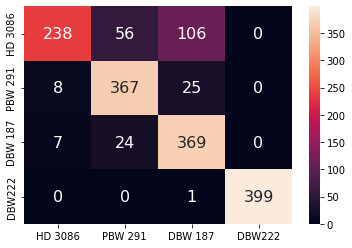

In [38]:
df_cm = pd.DataFrame(cm,index =[i for i in VARIETIES],columns=[i for i in VARIETIES])
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='.0f') # font size

plt.show()